# Dynamic Programming with Interpolation
### by [Richard W. Evans](https://sites.google.com/site/rickecon/), May 2019
The code in this Jupyter notebook was written using Python 3.7.

## 1. Introduction

### 1.1. Problem setup
Last term, we worked through an [introduction to dynamic programming](https://github.com/UC-MACSS/persp-model-econ_W19/blob/master/Notes/DynProg_Evans.pdf) in which we studied a stylized cake eating problem in order to introduce the topic and give a general structure of the problem.

A general form of the Bellman equation of a recursive model is the following,
\begin{equation}\label{DynProg_EqBellmanGen}
  V(x,y) = \max_{y'}\:\sigma(x,y,y') + \beta E\left[V(x',y')\right]
\end{equation}
where $x$ is the exogenous state (set of exogenous variables), $y$ is the endogenous state (set of choice variables), $y'$ is the control or choice variable, $\sigma(\cdot)$ is the period objective function, and $V(x,y)$ is the value function. The value function tells you the value to the agent of showing up in a given period with state $(x,y)$, and the value function accounts for all expected future benefits in addition to the current period benefits.

In our specific cake eating problem, we built up to the infinite horizon cake eater in Section 4. The size of the cake today is $W$, the utility of consumption today $u(c)$ is some continuous, monotonic, and concave function of $c$, and the law of motion for the size of the cake is $W'=W - c$, where $W'$ is the size of the cake tomorrow. With these definitions, we characterized the infinite horizon deterministic cake eating problem in Section 4 with the following Bellman equation.
\begin{equation}\label{DynProg_EqBellman}
  V\left(W\right) = \max_{W'\in[0,W]}\:\: u\left(W - W'\right) + \beta V\left(W'\right)
\end{equation}

### 1.2. Value function iteration solution method
In Section 4, we learned the conditions under which the iterative approach of value function iteration converges to the unique functional solution. We defined an operator $C(\cdot)$ (a function that executes specific operations) on a guess for the solution to the value function $V_t(W)$.
\begin{equation}\label{DynProg_EqContraction}
  C\Bigl(V_t\left(W\right)\Bigr) \equiv \max_{W'\in[0,W]}\: u\left(W-W'\right) + \beta V_t\left(W'\right)
\end{equation}
And we showed that under certain conditions, repeating this operation iteratively on a guess for the value function creates output that converges to the functional solution of the Bellman equation.

### 1.3. Our discretized, simplified approach
In the [dynamic programming chapter](https://github.com/UC-MACSS/persp-model-econ_W19/blob/master/Notes/DynProg_Evans.pdf) from last term, we used a simplified approach in which we only allowed a discrete number of cake sizes for the solution.
\begin{equation}
  \underset{\begin{bmatrix}W_1 \\ W_2 \\ \vdots \\ W_N\end{bmatrix}}{W,W'},\qquad \underset{\begin{bmatrix}V_{t+1}(W_1) \\ V_{t+1}(W_2) \\ \vdots \\ V_{t+1}(W_N)\end{bmatrix} =}{V_{t+1}(W)} = \max_{W'\in[0,W]}\underset{\begin{bmatrix}-10^{10} & -10^{10} & ... & -10^{10} \\ u(W_2 - W_1) & -10^{10} & ... & -10^{10} \\ \vdots & \vdots & \ddots & \vdots \\ u(W_N-W_1) & u(W_N - W_2) & ... & -10^{10}\end{bmatrix}}{u(W-W')} + \underset{+\beta\begin{bmatrix}-10^{10} & -10^{10} & ... & -10^{10} \\ V_t(W_1) & -10^{10} & ... & -10^{10} \\ \vdots & \vdots & \ddots & \vdots \\ V_t(W_1) & V_t(W_2) & ... & -10^{10}\end{bmatrix}}{\beta V_t(W')}
\end{equation}

## 2. Interpolation instead of discrete support for control
In this solution method with interpolation, we still have to discretize our guess for the state space $W$. But we will allow for our control variable $W'$ to be a continuum between 0 and $W$. Let's go back to the contraction version of our problem.
\begin{equation}
  V_{t+1}(W) = C\Bigl(V_t\left(W\right)\Bigr) \equiv \max_{W'\in[0,W]}\: u\left(W-W'\right) + \beta V_t\left(W'\right)
\end{equation}

The steps to solving each iteration are similar.
1. Choose a discrete grid for cake size $W = [W_1, W_2, ... W_N]^T$, where $W_1 > 0$ and $W_N\leq W_{max}$.
2. Guess an initial value function over this grid $V_t(W)$.

<IPython.core.display.Javascript object>


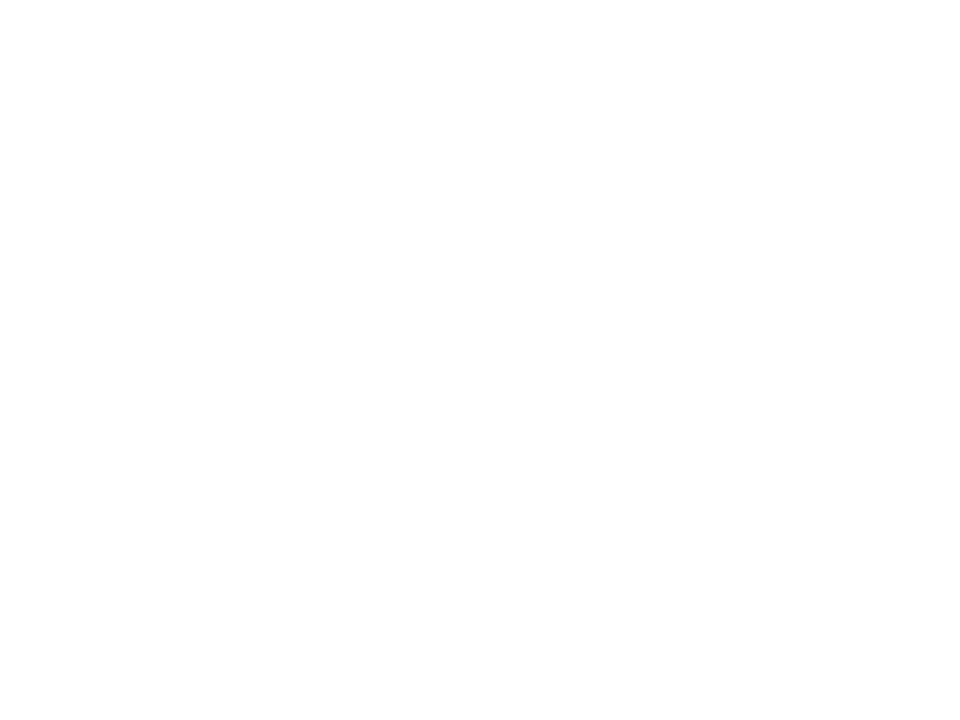

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

W_vec = np.linspace(0.1, 3, 30)
V_t = np.log(W_vec)

plt.scatter(W_vec, V_t)

### 2.1. Solving the Bellman for one initial point
Now imagine trying to solve the equation above for one particular cakesize.
\begin{equation}
  V_{t+1}(W_{10}) = \max_{W'\in[0,W_{10}]}\: u\left(W_{10}-W'\right) + \beta V_t\left(W'\right)
\end{equation}
What do we know? We know the cake size today $W_{10}$. And we know our guess for the entire value function $V_t(W)$, where our guess is for the value function at all of the discrete points in $W$. So the objects in the equation above are a scalar, a continuous utility function $u(W_{10}-W')$ of one variable $W'$, and a value function $V_t\left(W'\right)$ of one variable $W'$--a function that is currently discrete, but that we want to be continuous. Here is where we use interpolation. We interpolate a continuous function of $W'$ from the discrete points of our guess $V_t(W')$. This allows us to solve for the $W'$ that exactly solves for the equation above for the current state $W_{10}$.

Let the utility of consumption be CRRA with coefficient of relative risk aversion $\gamma=2.2$. Let our discretization of the possible cake sizes $W$ be 30 equally spaced cake sizes between 0.1 and 10. And let our initial guess for the value of cake size today be $V_t(W)=\ln(W)$.

In [2]:
import numpy as np
import scipy.optimize as opt
import scipy.interpolate as intpl
import matplotlib.pyplot as plt
%matplotlib notebook

# Set up the parameters
beta = 0.9
gamma = 2.2
W_min = 0.1
W_max = 10.0
W_size = 30
W_vec = np.linspace(W_min, W_max, W_size)
V_t = np.log(W_vec)

def util_CRRA(W, W_pr, gamma):
    # Define CRRA utility function
    c = W - W_pr
    util = (c ** (1 - gamma) - 1) / (1 - gamma)
    
    return util

def neg_V(W_pr, *args):
    W_init, util, V_t_interp, gamma, beta = args
    Vtp1 = util(W_init, W_pr, gamma) + beta * V_t_interp(W_pr)
    neg_Vtp1 = -Vtp1
    
    return neg_Vtp1

In [3]:
# Do the interpolation outside the minimization because it
# doesn't change for different W' cake sizes
V_t_interp = intpl.interp1d(W_vec, V_t, kind='cubic',
                            fill_value='extrapolate')

Look at what the interpolation function does to our discretized guess.

<IPython.core.display.Javascript object>


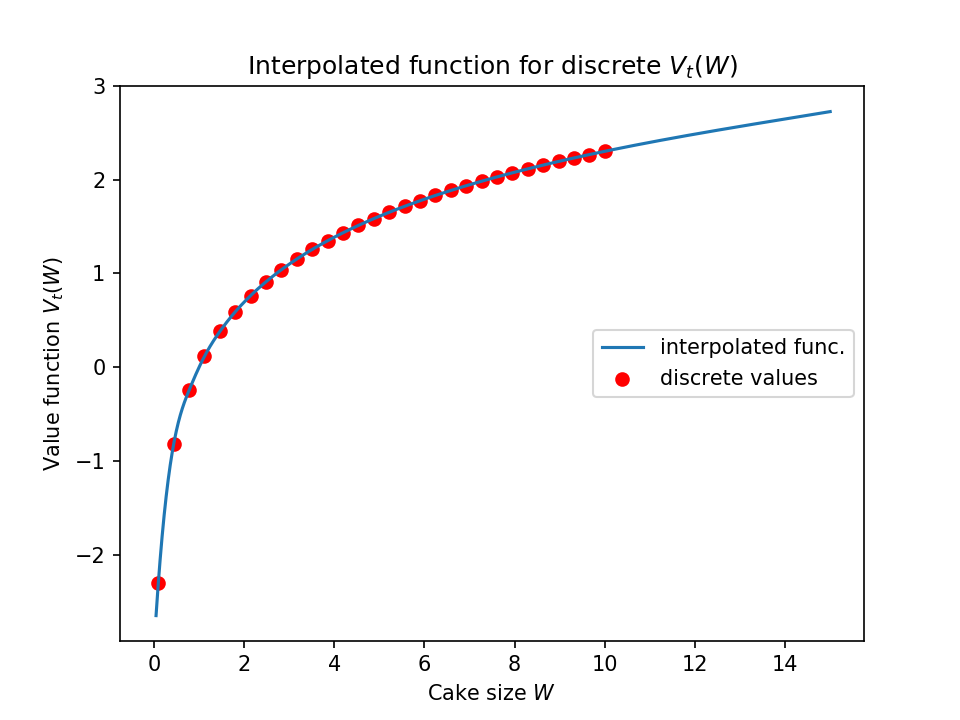

In [4]:
W_vec_lots = np.linspace(0.5* W_min, 1.5 * W_max, 1000)
plt.plot(W_vec_lots, V_t_interp(W_vec_lots), label='interpolated func.')
plt.scatter(W_vec, V_t, color='red', label='discrete values')
plt.title('Interpolated function for discrete $V_t(W)$')
plt.xlabel('Cake size $W$')
plt.ylabel('Value function $V_t(W)$')
plt.legend(loc='center right')

In [5]:
# Solve for optimal W_pr given W_init and a guess for the value function
W_init = W_vec[10]

V_args = (W_init, util_CRRA, V_t_interp, gamma, beta)
results_one = opt.minimize_scalar(neg_V, bounds=(1e-10, W_init - 1e-10),
                                  args=V_args, method='bounded')
print(results_one)

     fun: -0.9519492043004409
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 2.05675794339993


The optimal cake size gives us one point of our policy function $W' = \psi(W_{10})$. Note that the optimal $W'$ is not in the discretized support of $W$.

In [6]:
print('W_init=', W_init, ', W_pr=', results_one.x)

W_init= 3.513793103448276 , W_pr= 2.05675794339993


Now we can calculate the value of coming into the period with cake size $W_{10}$. It is simply the negative of the function value above.

In [7]:
V_tp1_10 = -results_one.fun
print('V_tp1_10=', V_tp1_10)

V_tp1_10= 0.9519492043004409


How does this compare to our initial guess for the value of coming in to the period with cake size $V_t(W_{10})$?

In [8]:
print('V_t_10 guess=', V_t[10], ', and V_tp1_10=', V_tp1_10)

V_t_10 guess= 1.2566961102422052 , and V_tp1_10= 0.9519492043004409


### 2.2. Solving the Bellman for all points in the support
The next step is obviously to solve the operator for all points in the discretized support of cake size $W$.

In [9]:
V_tp1_vec = np.zeros(W_size)
psi_vec = np.zeros(W_size)

for W_ind in range(W_size):
    W_init = W_vec[W_ind]
    V_args = (W_init, util_CRRA, V_t_interp, gamma, beta)
    results_all = opt.minimize_scalar(neg_V, bounds=(1e-10, W_init - 1e-10), args=V_args, method='bounded')
    V_tp1_vec[W_ind] = -results_all.fun
    psi_vec[W_ind] = results_all.x

<IPython.core.display.Javascript object>


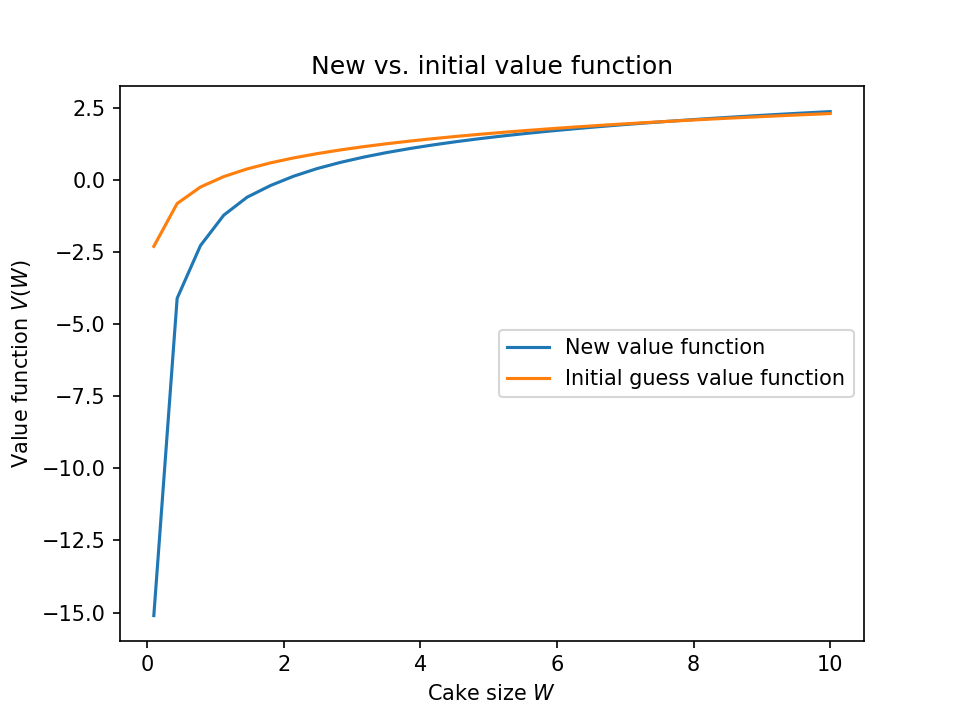

In [10]:
# Plot the new and initial value functions
plt.plot(W_vec, V_tp1_vec, label='New value function')
plt.plot(W_vec, V_t, label='Initial guess value function')
plt.title('New vs. initial value function')
plt.xlabel('Cake size $W$')
plt.ylabel('Value function $V(W)$')
plt.legend(loc='center right')

<IPython.core.display.Javascript object>


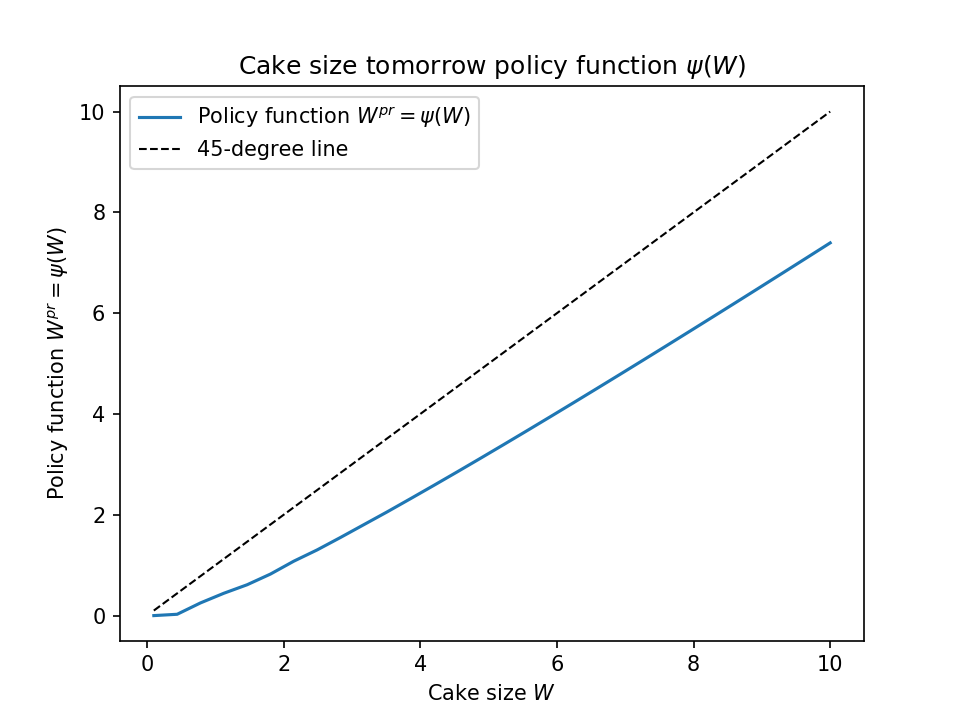

In [11]:
# Plot the resulting policy function
plt.plot(W_vec, psi_vec, label='Policy function $W^{pr}=\psi(W)$')
plt.plot(W_vec, W_vec, color='black', linewidth=1, linestyle='--',
         label='45-degree line')
plt.title('Cake size tomorrow policy function $\psi(W)$')
plt.xlabel('Cake size $W$')
plt.ylabel('Policy function $W^{pr}=\psi(W)$')
plt.legend()

In [12]:
V_t = V_tp1_vec.copy()
V_t_interp = intpl.interp1d(W_vec, V_t, kind='cubic',
                            fill_value='extrapolate')

V_tp1_vec = np.zeros(W_size)
psi_vec = np.zeros(W_size)

for W_ind in range(W_size):
    W_init = W_vec[W_ind]
    V_args = (W_init, util_CRRA, V_t_interp, gamma, beta)
    results_all = opt.minimize_scalar(neg_V, bounds=(1e-10, W_init - 1e-10), args=V_args, method='bounded')
    V_tp1_vec[W_ind] = -results_all.fun
    psi_vec[W_ind] = results_all.x

<IPython.core.display.Javascript object>


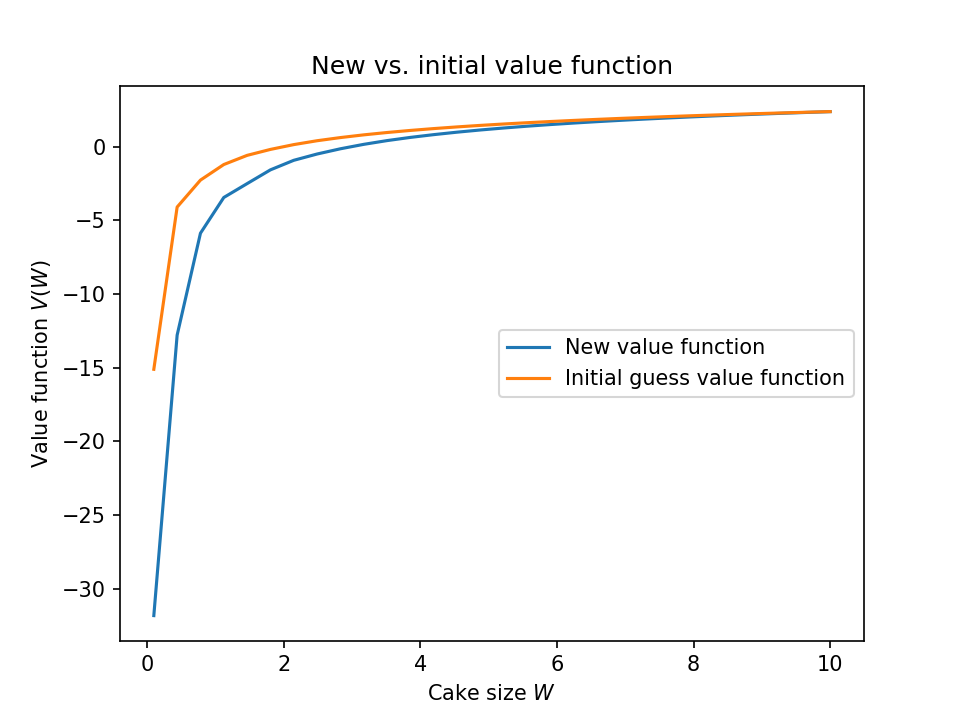

In [13]:
# Plot the new and initial value functions
plt.plot(W_vec, V_tp1_vec, label='New value function')
plt.plot(W_vec, V_t, label='Initial guess value function')
plt.title('New vs. initial value function')
plt.xlabel('Cake size $W$')
plt.ylabel('Value function $V(W)$')
plt.legend(loc='center right')

### 2.3. Do value function iteration with interpolation
Now we just need to update our guess and repeat until convergence.

In [14]:
from time import sleep
V_init = np.log(W_vec)
V_new = V_init.copy()

VF_iter = 0
VF_dist = 10
VF_maxiter = 200
VF_mindist = 1e-8

while (VF_iter < VF_maxiter) and (VF_dist > VF_mindist):
    # sleep(0.3)
    VF_iter += 1
    V_init = V_new.copy()
    V_new = np.zeros(W_size)
    psi_vec = np.zeros(W_size)
    
    V_init_interp = intpl.interp1d(W_vec, V_init, kind='cubic',
                                   fill_value='extrapolate')

    for W_ind in range(W_size):
        W_init = W_vec[W_ind]
        V_args = (W_init, util_CRRA, V_init_interp, gamma, beta)
        results_all = opt.minimize_scalar(neg_V, bounds=(1e-10, W_init - 1e-10),
                                          args=V_args, method='bounded')
        V_new[W_ind] = -results_all.fun
        psi_vec[W_ind] = results_all.x
    
    VF_dist = ((V_init - V_new) ** 2).sum()
    print('VF_iter=', VF_iter, ', VF_dist=', VF_dist)

VF_iter= 1 , VF_dist= 183.49767611191382
VF_iter= 2 , VF_dist= 382.09735456944736
VF_iter= 3 , VF_dist= 518.9591988798101
VF_iter= 4 , VF_dist= 612.9770157732069
VF_iter= 5 , VF_dist= 669.5393568584349
VF_iter= 6 , VF_dist= 694.7420303913711
VF_iter= 7 , VF_dist= 694.9947939190713
VF_iter= 8 , VF_dist= 676.3121149521533
VF_iter= 9 , VF_dist= 644.0285119740778
VF_iter= 10 , VF_dist= 602.6547311400199
VF_iter= 11 , VF_dist= 555.7434817510805
VF_iter= 12 , VF_dist= 506.1383774138148
VF_iter= 13 , VF_dist= 456.23445764810356
VF_iter= 14 , VF_dist= 407.80514198112786
VF_iter= 15 , VF_dist= 361.58215403025224
VF_iter= 16 , VF_dist= 318.365193267002
VF_iter= 17 , VF_dist= 278.6141247485377
VF_iter= 18 , VF_dist= 242.53447574894085
VF_iter= 19 , VF_dist= 210.14657376807315
VF_iter= 20 , VF_dist= 181.33781003296045
VF_iter= 21 , VF_dist= 155.9069365570751
VF_iter= 22 , VF_dist= 133.59979397943022
VF_iter= 23 , VF_dist= 114.13655624734754
VF_iter= 24 , VF_dist= 97.23126714690702
VF_iter= 25 , VF

<IPython.core.display.Javascript object>


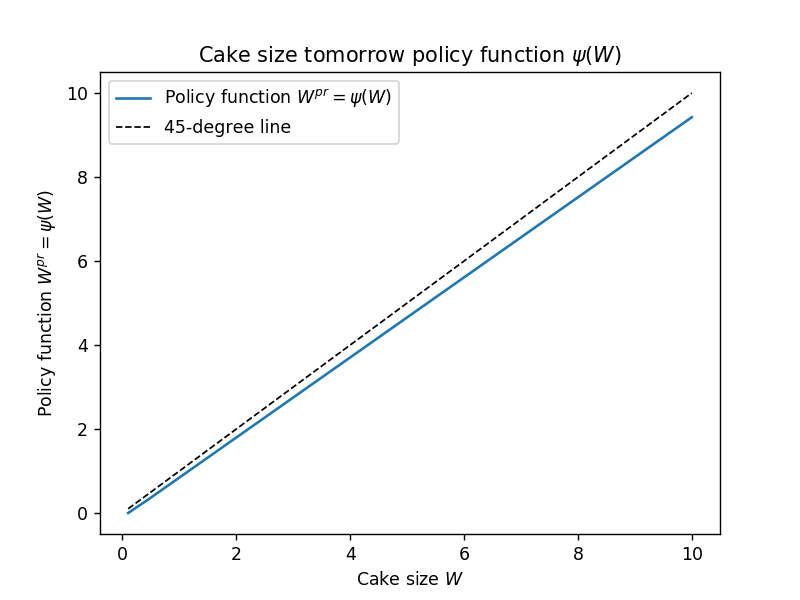

In [15]:
# Plot the resulting policy function
plt.plot(W_vec, psi_vec, label='Policy function $W^{pr}=\psi(W)$')
plt.plot(W_vec, W_vec, color='black', linewidth=1, linestyle='--',
         label='45-degree line')
plt.title('Cake size tomorrow policy function $\psi(W)$')
plt.xlabel('Cake size $W$')
plt.ylabel('Policy function $W^{pr}=\psi(W)$')
plt.legend()

<IPython.core.display.Javascript object>


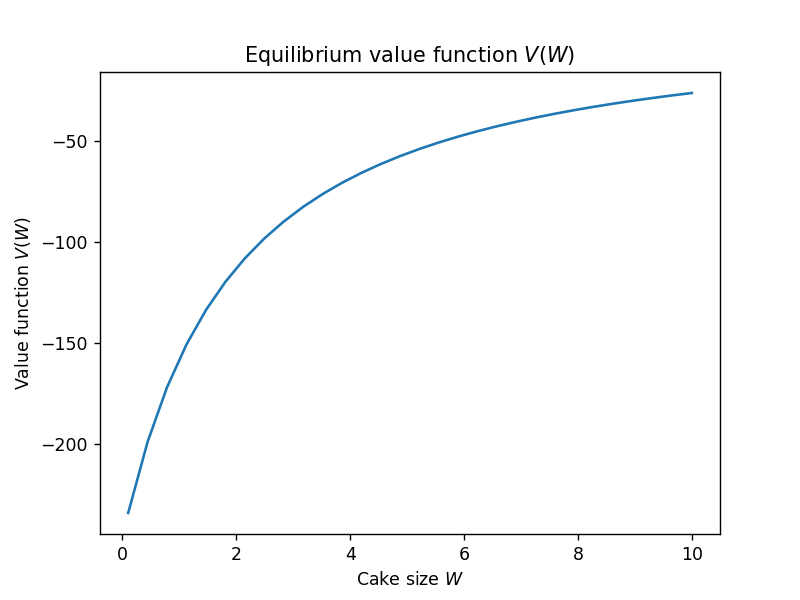

Text(0, 0.5, 'Value function $V(W)$')

In [16]:
# Plot the equilibrium value function
plt.plot(W_vec, V_new)
plt.title('Equilibrium value function $V(W)$')
plt.xlabel('Cake size $W$')
plt.ylabel('Value function $V(W)$')

## 3. Solving problem with stochastic utility
In this section, I will give you the intuition and outline of how to solve the cake eating problem with i.i.d. stochastic utility shocks from Section 5 of the [dynamic programming introduction](https://github.com/UC-MACSS/persp-model-econ_W19/blob/master/Notes/DynProg_Evans.pdf) and the probelm with persistent stochastic utility shocks from Section 6 of the [dynamic programming introduction](https://github.com/UC-MACSS/persp-model-econ_W19/blob/master/Notes/DynProg_Evans.pdf). You will solve these as your problem set.

In [19]:
eps_vec = np.array([-1.40, -0.55, 0.0, 0.55, 1.4])
eps_prob = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
eps_size = eps_vec.shape[0]

In [21]:
def neg_V_iid(W_pr, *args):
    W, eps, util, Exp_V_t_interp, gamma, beta = args
    Vtp1 = np.exp(eps) * util(W, W_pr, gamma) + beta * Exp_V_t_interp(W_pr)
    neg_Vtp1 = -Vtp1
    
    return neg_Vtp1

In [28]:
V_init = np.zeros((W_size, eps_size))
V_new = V_init.copy()

VF_iter = 0
VF_dist = 10
VF_maxiter = 200
VF_mindist = 1e-8

while (VF_iter < VF_maxiter) and (VF_dist > VF_mindist):
    VF_iter += 1
    V_init = V_new.copy()
    V_new = np.zeros((W_size, eps_size))
    psi_mat = np.zeros((W_size, eps_size))
    
    # Integrate out eps_pr from V_init
    Exp_V = V_init @ eps_prob.reshape((eps_size, 1))
    
    # Interpolate expected value function
    Exp_V_interp = intpl.interp1d(W_vec, Exp_V.flatten(), kind='cubic',
                                   fill_value='extrapolate')

    for eps_ind in range(eps_size):
        for W_ind in range(W_size):
            W = W_vec[W_ind]
            eps = eps_vec[eps_ind]
            V_args = (W, eps, util_CRRA, Exp_V_interp, gamma, beta)
            results1 = opt.minimize_scalar(neg_V_iid, bounds=(1e-10, W - 1e-10),
                                           args=V_args, method='bounded')
            V_new[W_ind, eps_ind] = -results1.fun
            psi_mat[W_ind, eps_ind] = results1.x
    
    VF_dist = ((V_init - V_new) ** 2).sum()
    print('VF_iter=', VF_iter, ', VF_dist=', VF_dist)
    
V_1 = V_new.copy()
psi_1 = psi_mat.copy()

VF_iter= 1 , VF_dist= 3494.416552492849
VF_iter= 2 , VF_dist= 484.01517676147824
VF_iter= 3 , VF_dist= 86.14162174942308
VF_iter= 4 , VF_dist= 14.118534453256721
VF_iter= 5 , VF_dist= 2.1959939140961344
VF_iter= 6 , VF_dist= 0.3127198546485359
VF_iter= 7 , VF_dist= 0.03878656613927543
VF_iter= 8 , VF_dist= 0.004104227361292752
VF_iter= 9 , VF_dist= 0.0003803472774451377
VF_iter= 10 , VF_dist= 3.3096064132147566e-05
VF_iter= 11 , VF_dist= 2.864404146655014e-06
VF_iter= 12 , VF_dist= 2.5218447079495656e-07
VF_iter= 13 , VF_dist= 2.2554299872765197e-08
VF_iter= 14 , VF_dist= 2.0325713648415907e-09


<IPython.core.display.Javascript object>


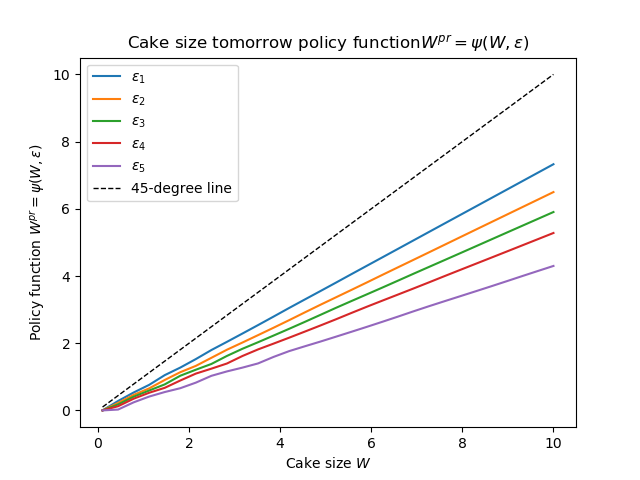

In [29]:
# Plot the resulting policy function
plt.plot(W_vec, psi_1[:, 0], label='$\epsilon_1$')
plt.plot(W_vec, psi_1[:, 1], label='$\epsilon_2$')
plt.plot(W_vec, psi_1[:, 2], label='$\epsilon_3$')
plt.plot(W_vec, psi_1[:, 3], label='$\epsilon_4$')
plt.plot(W_vec, psi_1[:, 4], label='$\epsilon_5$')
plt.plot(W_vec, W_vec, color='black', linewidth=1, linestyle='--',
         label='45-degree line')
plt.title('Cake size tomorrow policy function' +
          '$W^{pr}=\psi(W,\epsilon)$')
plt.xlabel('Cake size $W$')
plt.ylabel('Policy function $W^{pr}=\psi(W,\epsilon)$')
plt.legend()

<IPython.core.display.Javascript object>


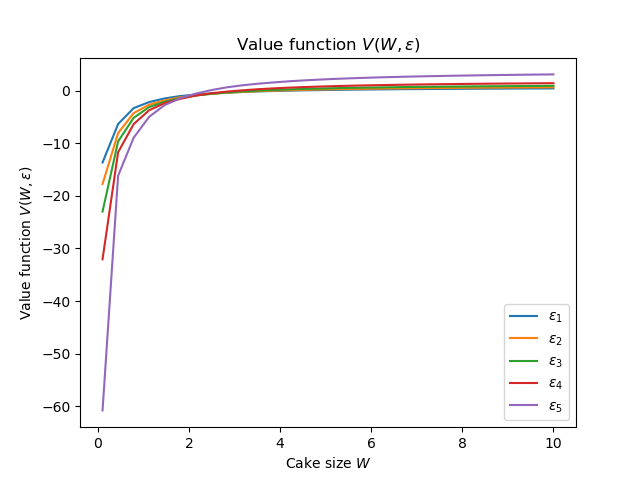

In [30]:
# Plot the resulting value function
plt.plot(W_vec, V_1[:, 0], label='$\epsilon_1$')
plt.plot(W_vec, V_1[:, 1], label='$\epsilon_2$')
plt.plot(W_vec, V_1[:, 2], label='$\epsilon_3$')
plt.plot(W_vec, V_1[:, 3], label='$\epsilon_4$')
plt.plot(W_vec, V_1[:, 4], label='$\epsilon_5$')
plt.title('Value function $V(W,\epsilon)$')
plt.xlabel('Cake size $W$')
plt.ylabel('Value function $V(W,\epsilon)$')
plt.legend()

## Exercise 2 stuff

In [32]:
trans_mat = np.array([[0.40, 0.28, 0.18, 0.10, 0.04],
                      [0.20, 0.40, 0.20, 0.13, 0.07],
                      [0.10, 0.20, 0.40, 0.20, 0.10],
                      [0.07, 0.13, 0.20, 0.40, 0.20],
                      [0.04, 0.10, 0.18, 0.28, 0.40]])

In [33]:
V_init = np.zeros((W_size, eps_size))
V_new = V_init.copy()

VF_iter = 0
VF_dist = 10
VF_maxiter = 200
VF_mindist = 1e-8

while (VF_iter < VF_maxiter) and (VF_dist > VF_mindist):
    VF_iter += 1
    V_init = V_new.copy()
    V_new = np.zeros((W_size, eps_size))
    psi_mat = np.zeros((W_size, eps_size))
    
    

    for eps_ind in range(eps_size):
        # Calculate expected value, integrate out epsilon prime
        trans_mat_ind = trans_mat[eps_ind, :]
        Exp_V = V_init @ trans_mat_ind.reshape((eps_size, 1))
        
        # Interpolate expected value function
        Exp_V_interp = intpl.interp1d(W_vec, Exp_V.flatten(), kind='cubic',
                                      fill_value='extrapolate')
        for W_ind in range(W_size):
            W = W_vec[W_ind]
            eps = eps_vec[eps_ind]
            V_args = (W, eps, util_CRRA, Exp_V_interp, gamma, beta)
            results1 = opt.minimize_scalar(neg_V_iid, bounds=(1e-10, W - 1e-10),
                                           args=V_args, method='bounded')
            V_new[W_ind, eps_ind] = -results1.fun
            psi_mat[W_ind, eps_ind] = results1.x
    
    VF_dist = ((V_init - V_new) ** 2).sum()
    print('VF_iter=', VF_iter, ', VF_dist=', VF_dist)
    
V_2 = V_new.copy()
psi_2 = psi_mat.copy()

VF_iter= 1 , VF_dist= 3494.416552492849
VF_iter= 2 , VF_dist= 734.3175517443889
VF_iter= 3 , VF_dist= 115.6709275498389
VF_iter= 4 , VF_dist= 17.91491344184249
VF_iter= 5 , VF_dist= 2.684471647415198
VF_iter= 6 , VF_dist= 0.3678848104604137
VF_iter= 7 , VF_dist= 0.044228688026908165
VF_iter= 8 , VF_dist= 0.004600136590070555
VF_iter= 9 , VF_dist= 0.0004257828536497002
VF_iter= 10 , VF_dist= 3.7081185133578585e-05
VF_iter= 11 , VF_dist= 3.1914266541747064e-06
VF_iter= 12 , VF_dist= 2.780835597415564e-07
VF_iter= 13 , VF_dist= 2.462530818327997e-08
VF_iter= 14 , VF_dist= 2.2052980647086556e-09


<IPython.core.display.Javascript object>


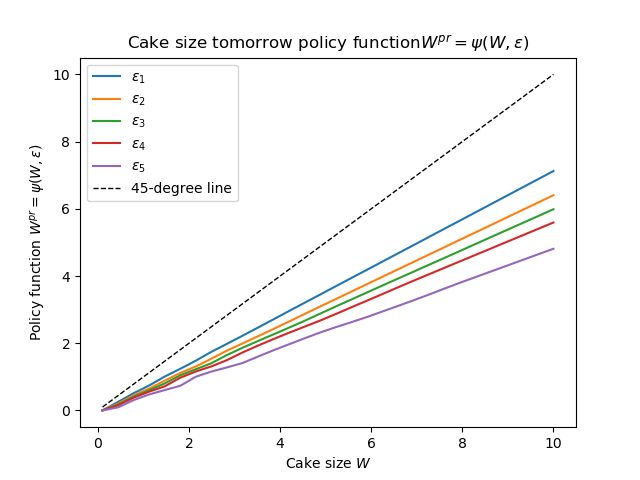

In [34]:
# Plot the resulting policy function
plt.plot(W_vec, psi_2[:, 0], label='$\epsilon_1$')
plt.plot(W_vec, psi_2[:, 1], label='$\epsilon_2$')
plt.plot(W_vec, psi_2[:, 2], label='$\epsilon_3$')
plt.plot(W_vec, psi_2[:, 3], label='$\epsilon_4$')
plt.plot(W_vec, psi_2[:, 4], label='$\epsilon_5$')
plt.plot(W_vec, W_vec, color='black', linewidth=1, linestyle='--',
         label='45-degree line')
plt.title('Cake size tomorrow policy function' +
          '$W^{pr}=\psi(W,\epsilon)$')
plt.xlabel('Cake size $W$')
plt.ylabel('Policy function $W^{pr}=\psi(W,\epsilon)$')
plt.legend()

<IPython.core.display.Javascript object>


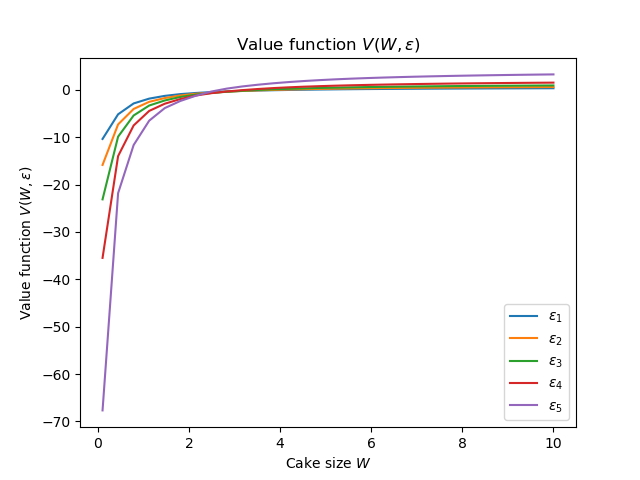

In [35]:
# Plot the resulting value function
plt.plot(W_vec, V_2[:, 0], label='$\epsilon_1$')
plt.plot(W_vec, V_2[:, 1], label='$\epsilon_2$')
plt.plot(W_vec, V_2[:, 2], label='$\epsilon_3$')
plt.plot(W_vec, V_2[:, 3], label='$\epsilon_4$')
plt.plot(W_vec, V_2[:, 4], label='$\epsilon_5$')
plt.title('Value function $V(W,\epsilon)$')
plt.xlabel('Cake size $W$')
plt.ylabel('Value function $V(W,\epsilon)$')
plt.legend()